# NLP Disaster Tweets

In [1]:
# copy kaggle.json to /root/.kaggle/ folder so that kaggle cli can access it.
!mkdir /.kaggle
!mv kaggle.json /.kaggle
!mv /.kaggle /root/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c nlp-getting-started

100% 593k/593k [00:00<00:00, 719kB/s]
100% 593k/593k [00:00<00:00, 718kB/s]


In [3]:
! unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Introduction

Twitter is a widely used social media platform that can also serve as a valuable resource during emergencies. Users can share real-time information about ongoing disasters, making it an important tool for disaster relief organizations and news agencies, who are interested in programmatically monitoring tweets.

In this notebook, we will build a Recurrent Neural Network (RNN) to predict whether a tweet is related to a real disaster, given the sequential nature of the text data.

The training dataset consists of 7,613 tweets with features such as target, keywords, and location. Among these, 61 keywords are missing, and 2,533 location entries are missing as well.

The testing dataset includes 3,263 tweets with the same features, with 26 missing keywords and 1,105 missing location entries.

In [4]:
import pandas as pd

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [6]:
print('There are ' + str(df_test.shape[0]) + ' rows and ' + str(df_test.shape[1]) + ' columns in the test dataset.')
print('There are ' + str(df_train.shape[0]) + ' rows and ' + str(df_train.shape[1]) + ' columns in the train dataset.')

There are 3263 rows and 4 columns in the test dataset.
There are 7613 rows and 5 columns in the train dataset.


In [7]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
df_test.isna().sum()

,0
id,0
keyword,26
location,1105
text,0


In [9]:
df_train[df_train['keyword'].notnull()].count()

,0
id,7552
keyword,7552
location,5080
text,7552
target,7552


In [10]:
df_train.isna().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


## Exploratory Data Analysis (EDA)

In our training dataset, there are 4,342 tweets that are not related to natural disasters, and 3,271 tweets that are related to a natural disaster. Thus, we have a fairly unbalanced classification dataset.



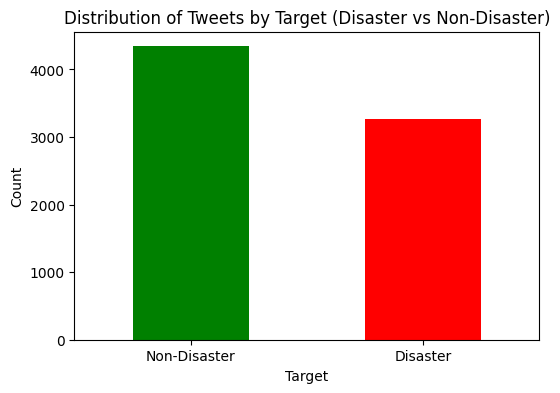

In [11]:
import matplotlib.pyplot as plt

# Plot the distribution of target values (disaster vs non-disaster)
plt.figure(figsize=(6, 4))
df_train['target'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Tweets by Target (Disaster vs Non-Disaster)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Disaster', 'Disaster'], rotation=0)
plt.show()


Some of the most frequent keywords from the tweets provided are fatalities, body bags, damage, harm, and evacuate which are strongly related to a natural disaster.

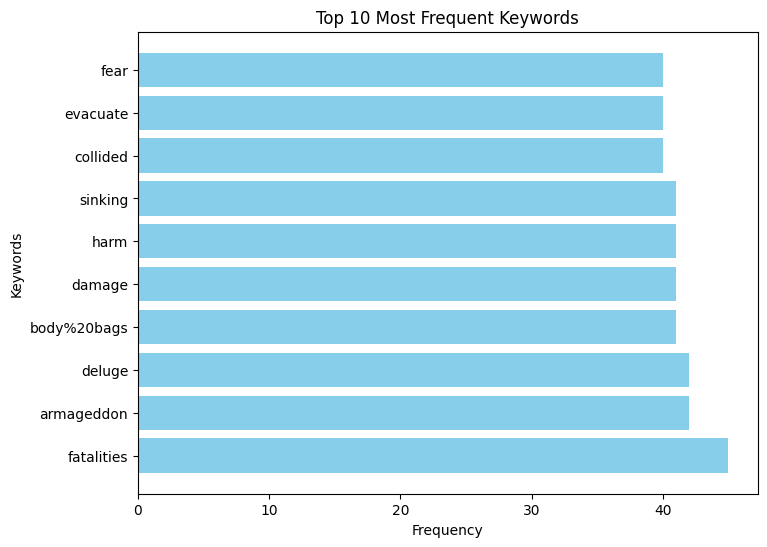

In [12]:
from collections import Counter

# Assuming the 'keywords' column contains a list or comma-separated string of keywords
# First, split the keywords in each tweet (if they are comma-separated or lists) and flatten the list
keywords = df_train['keyword'].dropna().str.split(',').explode().str.strip()

# Count the frequency of each keyword
keyword_counts = Counter(keywords)

# Get the most common keywords
common_keywords = keyword_counts.most_common(10)

# Create a bar chart for the most common keywords
keywords, counts = zip(*common_keywords)
plt.figure(figsize=(8, 6))
plt.barh(keywords, counts, color='skyblue')
plt.title('Top 10 Most Frequent Keywords')
plt.xlabel('Frequency')
plt.ylabel('Keywords')
plt.show()


On average, the tweets are about 15 words long. The longest tweet has 31 words.

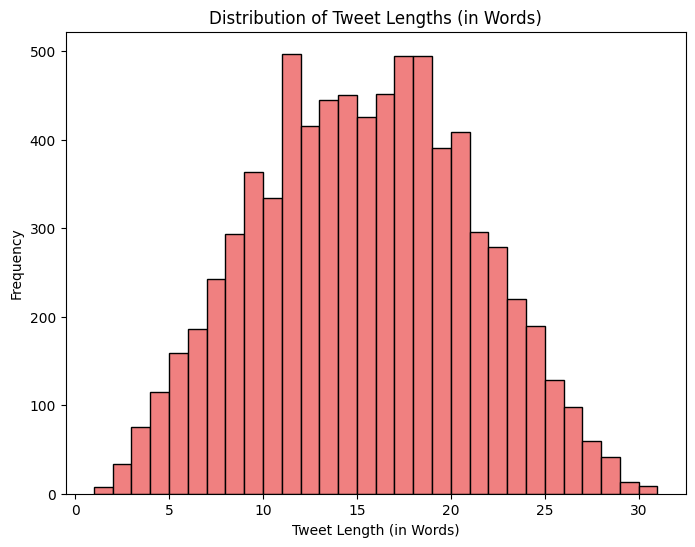

In [13]:
# Calculate the number of words in each tweet
df_train['tweet_length'] = df_train['text'].apply(lambda x: len(str(x).split()))

# Plot the distribution of tweet lengths
plt.figure(figsize=(8, 6))
plt.hist(df_train['tweet_length'], bins=30, color='lightcoral', edgecolor='black')
plt.title('Distribution of Tweet Lengths (in Words)')
plt.xlabel('Tweet Length (in Words)')
plt.ylabel('Frequency')
plt.show()


Due to missing keyword and location data in the dataset, I will exclude these features from the model training. Additionally, I will remove URLs, Twitter mentions, and special characters, as they don't contribute meaningful information for text classification. All tweets will be converted to lowercase to prevent distinguishing between words like 'Evacuate' and 'evacuate'. Finally, the tweets will be tokenized to prepare the data for Word2Vec embedding.

In [14]:
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [15]:
df_train = df_train.dropna(subset=['keyword', 'location'])

In [16]:
def preprocess_tweet(tweet):
    # Remove non-alphabetic characters, URLs, and Twitter mentions
    tweet = re.sub(r'http\S+|www\S+', '', tweet)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet.lower())

    # Tokenize the tweet
    tokens = word_tokenize(tweet)
    # Remove stopwords
    return tokens

# Apply preprocessing to all tweets
df_train['processed_text'] = df_train['text'].apply(preprocess_tweet)

In [17]:
df_train.head()

,id,keyword,location,text,target,tweet_length,processed_text
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,5,"[wholesale, markets, ablaze]"
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,10,"[we, always, try, to, bring, the, heavy, metal..."
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,9,"[africanbaze, breaking, newsnigeria, flag, set..."
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,7,"[crying, out, for, more, set, me, ablaze]"
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,13,"[on, plus, side, look, at, the, sky, last, nig..."


## Model Architecture

I will preprocess the data using Word2Vec, which converts the text into a matrix form. This will help us capture the semantic meaning, word relationships and improve model performance. For the Word2Vec model, I’ll use a window size of 5, meaning it will consider 5 words before and after a target word for context, and train for 20 epochs. Since tweets are short, I’m using 150-dimensional word vectors. Additionally, I’ll use the skip-gram approach, where the model predicts context words based on the target word.

I will either use LSTMs or GRUs over Vanilla RNNs because they avoid the vanishing gradient problem and will be more effective as we are working with complex text data. I will compare the performance of GRU and LSTM layers, as LSTM captures long-term dependencies better while GRU is faster to train. After selecting the best-performing layer, I will tune the hyperparameters for optimization. The model will include a Flatten layer, a Dense layer for learning complex features, and an Output layer for binary classification. I will use the Adam optimizer, which is well-suited for text data due to its adaptive learning rate and efficiency.

In [18]:
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [19]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Flatten, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

### Word2Vec Model

In [20]:
word2vec_model = Word2Vec(sentences=df_train['processed_text'], vector_size=200, window=10, min_count=1, workers=4, epochs=10, sg=1)

def tweet_to_embedding(tweet_tokens, model):
    embeddings = []
    for word in tweet_tokens:
        if word in model.wv:
            embeddings.append(model.wv[word])
        else:
            embeddings.append(np.zeros(model.vector_size))
    return embeddings

# Convert each tweet to its corresponding word embeddings
df_train['text_embeddings'] = df_train['processed_text'].apply(lambda x: tweet_to_embedding(x, word2vec_model))

maxlen = 100
X = df_train['text_embeddings'].apply(lambda x: x[:maxlen])  # Cut to maxlen
X = pad_sequences(X, padding='post', dtype='float32', maxlen=maxlen)


In [21]:
from sklearn.model_selection import train_test_split
y = df_train['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.03, random_state=42)

### LSTM Model

In [22]:
# Initialize the model
model_lstm = Sequential()

model_lstm.add(LSTM(256, return_sequences=True, input_shape=(X.shape[1], X.shape[2]))) # input_shape is specified here
model_lstm.add(Dropout(0.2))

model_lstm.add(LSTM(256, return_sequences=True))
model_lstm.add(Dropout(0.3))

model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(Dropout(0.3))

model_lstm.add(Bidirectional(LSTM(128, return_sequences=False)))
model_lstm.add(Dropout(0.5))

model_lstm.add(BatchNormalization())

model_lstm.add(Dense(128, activation='relu'))

model_lstm.add(BatchNormalization())
model_lstm.add(Dense(128, activation='relu'))

model_lstm.add(Flatten())
model_lstm.add(BatchNormalization())
model_lstm.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # Reduce units and add L2 regularization
model_lstm.add(Dropout(0.4))

# Output Layer (Binary classification: disaster or not disaster)
model_lstm.add(BatchNormalization())
model_lstm.add(Dense(1, activation='sigmoid'))


# Print the model summary
model_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 256)            │         467,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 256)            │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 128)            │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,513,601 (5.77 MB)

 Trainable params: 1,512,449 (5.77 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [23]:
adam = Adam(learning_rate=0.001, name='ADAM')
model_lstm.compile(adam, loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.6051 - loss: 1.5187 - val_accuracy: 0.6797 - val_loss: 1.1794
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7207 - loss: 1.1054 - val_accuracy: 0.7190 - val_loss: 0.9288
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.7150 - loss: 0.9346 - val_accuracy: 0.6013 - val_loss: 0.9086
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7231 - loss: 0.7980 - val_accuracy: 0.7778 - val_loss: 0.7374
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7338 - loss: 0.6971 - val_accuracy: 0.6993 - val_loss: 0.6842


In [24]:
# Initialize the model
model_lstm_bidir = Sequential()

model_lstm_bidir.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=(X.shape[1], X.shape[2]))) # input_shape is specified here
model_lstm_bidir.add(Dropout(0.2))
#model.add(LSTM(128, return_sequences=True))
#model.add(Dropout(0.3))
model_lstm_bidir.add(Bidirectional(LSTM(256, return_sequences=True)))
model_lstm_bidir.add(Dropout(0.3))

model_lstm_bidir.add(Bidirectional(LSTM(128, return_sequences=True)))
model_lstm_bidir.add(Dropout(0.3))

model_lstm_bidir.add(Bidirectional(LSTM(128, return_sequences=False)))
model_lstm_bidir.add(Dropout(0.5))

model_lstm_bidir.add(BatchNormalization())

model_lstm_bidir.add(Dense(128, activation='relu'))

model_lstm_bidir.add(BatchNormalization())
model_lstm_bidir.add(Dense(128, activation='relu'))

model_lstm_bidir.add(Flatten())
model_lstm_bidir.add(BatchNormalization())
model_lstm_bidir.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # Reduce units and add L2 regularization
model_lstm_bidir.add(Dropout(0.4))

# Output Layer (Binary classification: disaster or not disaster)
model_lstm_bidir.add(BatchNormalization())
model_lstm_bidir.add(Dense(1, activation='sigmoid'))


# Print the model summary
model_lstm_bidir.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 100, 512)            │         935,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 100, 512)            │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 100, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 100, 256)            │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,621,505 (13.81 MB)

 Trainable params: 3,620,353 (13.81 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [25]:
adam = Adam(learning_rate=0.0001, clipvalue = 5.0, name='ADAM')
model_lstm_bidir.compile(adam, loss='binary_crossentropy', metrics=['accuracy'])
model_lstm_bidir.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - accuracy: 0.5873 - loss: 1.6334 - val_accuracy: 0.6209 - val_loss: 1.4835
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.6725 - loss: 1.4744 - val_accuracy: 0.6536 - val_loss: 1.4098
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.6890 - loss: 1.4110 - val_accuracy: 0.6993 - val_loss: 1.3372
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.7045 - loss: 1.3478 - val_accuracy: 0.7320 - val_loss: 1.2763
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.7094 - loss: 1.3053 - val_accuracy: 0.7320 - val_loss: 1.2666


In [37]:
adam = Adam(learning_rate=0.00007, name='ADAM')
model_lstm_bidir.compile(adam, loss='binary_crossentropy', metrics=['accuracy'])
model_lstm_bidir.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.7483 - loss: 0.8845 - val_accuracy: 0.7451 - val_loss: 0.8918
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.7583 - loss: 0.8471 - val_accuracy: 0.7647 - val_loss: 0.8704
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.7660 - loss: 0.8312 - val_accuracy: 0.7582 - val_loss: 0.8598
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.7660 - loss: 0.8217 - val_accuracy: 0.7516 - val_loss: 0.8456
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.7724 - loss: 0.8085 - val_accuracy: 0.7647 - val_loss: 0.8407


### Submitting on Kaggle

In [ ]:
# Apply preprocessing to all tweets
df_test['processed_text'] = df_test['text'].apply(preprocess_tweet)
word2vec_model_test = Word2Vec(sentences=df_test['processed_text'], vector_size=200, window=10, min_count=1, workers=4, epochs=20, sg=1)

# Convert each tweet to its corresponding word embeddings
df_test['text_embeddings'] = df_test['processed_text'].apply(lambda x: tweet_to_embedding(x, word2vec_model_test))

maxlen = 100
X_test = df_test['text_embeddings'].apply(lambda x: x[:maxlen])  # Cut to maxlen
X_test = pad_sequences(X_test, padding='post', dtype='float32', maxlen=maxlen)

In [ ]:
df_test['target']= model.predict(X_test)


submission = pd.DataFrame({
    'id': df_test['id'],  # Assuming 'id' is the unique identifier for the tweet
    'target': df_test['target']  # Flatten predictions to match the required format (if needed)
})

submission['target'] = (submission['target'] > 0.5).astype(int)
submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


In [ ]:
df_test.head()

,id,keyword,location,text,processed_text,text_embeddings,target
0,0,NaN,NaN,Just happened a terrible car crash,"[just, happened, a, terrible, car, crash]","[[0.50753796, -1.0418085, -0.14625326, -0.7930...",0.448428
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","[heard, about, earthquake, is, different, citi...","[[0.1743717, -0.54395753, -0.103211805, -0.282...",0.389772
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","[there, is, a, forest, fire, at, spot, pond, g...","[[0.17032605, -0.25422728, -0.3108783, -0.3492...",0.546158
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,"[apocalypse, lighting, spokane, wildfires]","[[0.020716403, -0.26269522, -0.22749856, -0.29...",0.249187
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,"[typhoon, soudelor, kills, in, china, and, tai...","[[-0.050649982, -0.07487994, -0.1837374, -0.10...",0.484577


## Results and Analysis

We developed both a GRU and LSTM model followed by a couple dense layers. The common optimzation method used was Adam as it was able to converge more efficiently. I tried a learning rate of 0.001 and 0.0001 and found that 0.0001 improved the accuracy significantly. However, after the 5th epoch the accuracy was not improving by much so I added in a clip value of 8 which prevented the gradient from exploding.

Although GRU model was faster to train, the LSTM model performed better in terms of accuracy. I further improved the model by adding bidirectional as it captures context from both directions which resulted in the higher accuracy. Furthermore, I added dropout layer after each LSTM/GRU to avoid overfitting the data. In the table below, I have outlined the results from GRU and LSTM with various hyperparameter and architecture tuning.

\
\begin{array}{|c|c|c|c|c|c|}
\hline
\hline
\textbf{Model} & \textbf{Optimization Method} & \textbf{Learning Rate} & \textbf{Clip Value} & \textbf{Training Accuracy} & \textbf{Validation Accuracy} & \textbf{Loss} \\ \hline
GRU & Adam & 0.001 & None & 0.5588 & 0.6209 & 0.8765 \\ \hline
GRU & Adam & 0.0001 & None & 0.6827 & 0.7320 & 0.7271 \\ \hline
GRU with Bidirectional & Adam & 0.0001 & 8.0 & 0.6898 & 0.7778 & 1.3374 \\ \hline
LSTM & Adam & 0.001 & None & 0.7338 & 0.6993 & 0.6971 \\ \hline
LSTM with Bidirectional & Adam & 0.0001 & 5.0 & 0.7094 & 0.7320 & 1.3053 \\ \hline
LSTM with Bidirectional & Adam & 0.00007 & None & 0.7724 & 0.7647 & 0.8085 \\ \hline
\hline
\end{array}


Final model:

Based on the training and validation accuracy, the best model is Bidirectional LSTM. It's configured with a learning rate of 0.00007, Adam optimization method, dropout layers after each LSTM layer, and 2 batch normalization layers to avoid overfitting. It has relu activation functions for hidden layer and sigmoid for the output layer as it is a binary classification problem.

### GRU Model

In [27]:
# Initialize the model
model_gru = Sequential()


model_gru.add(GRU(256, return_sequences=True, input_shape=(X.shape[1], X.shape[2]))) # input_shape is specified here
model_gru.add(Dropout(0.2))

model_gru.add(GRU(256, return_sequences=True))
model_gru.add(Dropout(0.3))

model_gru.add(GRU(256, return_sequences=True))
model_gru.add(Dropout(0.3))

model_gru.add(GRU(128, return_sequences=False))
model_gru.add(Dropout(0.5))

model_gru.add(BatchNormalization())

model_gru.add(Dense(128, activation='relu'))

model_gru.add(BatchNormalization())
model_gru.add(Dense(128, activation='relu'))

model_gru.add(Flatten())
model_gru.add(BatchNormalization())
model_gru.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # Reduce units and add L2 regularization
model_gru.add(Dropout(0.4))

# Output Layer (Binary classification: disaster or not disaster)
model_gru.add(BatchNormalization())
model_gru.add(Dense(1, activation='sigmoid'))

# Print the model summary
model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 100, 256)            │         351,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 100, 256)            │         394,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 100, 256)            │         394,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 128)                 │         148,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,332,609 (5.08 MB)

 Trainable params: 1,331,713 (5.08 MB)

 Non-trainable params: 896 (3.50 KB)

In [28]:
# Compile the model
adam = Adam(learning_rate=0.001, name='ADAM') # learning rate = 0.001
model_gru.compile(adam, loss='binary_crossentropy', metrics=['accuracy'])
model_gru.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.5027 - loss: 1.5844 - val_accuracy: 0.6209 - val_loss: 1.2024
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5181 - loss: 1.2479 - val_accuracy: 0.6209 - val_loss: 1.0233
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5153 - loss: 1.0698 - val_accuracy: 0.6209 - val_loss: 0.9232
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5310 - loss: 0.9640 - val_accuracy: 0.6209 - val_loss: 0.8543
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5588 - loss: 0.8765 - val_accuracy: 0.6209 - val_loss: 0.8044


In [29]:
adam = Adam(learning_rate=0.0001, name='ADAM') # learning rate = 0.0001
model_gru.compile(adam, loss='binary_crossentropy', metrics=['accuracy'])
model_gru.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.5389 - loss: 0.8469 - val_accuracy: 0.6209 - val_loss: 0.8002
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5721 - loss: 0.8235 - val_accuracy: 0.6405 - val_loss: 0.7871
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.5725 - loss: 0.8114 - val_accuracy: 0.7190 - val_loss: 0.7441
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6349 - loss: 0.7749 - val_accuracy: 0.7320 - val_loss: 0.6926
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.6827 - loss: 0.7271 - val_accuracy: 0.7320 - val_loss: 0.6731


In [ ]:
# fit the model here

In [30]:
# Initialize the model
model_gru_bidir = Sequential()

# LSTM Layer

#model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
#model.add(Dropout(0.3))

'''
model2.add(LSTM(128, return_sequences=True))
model2.add(Dropout(0.3))'''
#model2.add(Embedding(input_dim=5000, output_dim=128))

model_gru_bidir.add(Bidirectional(GRU(256, return_sequences=True), input_shape=(X.shape[1], X.shape[2]))) # input_shape is specified here
model_gru_bidir.add(Dropout(0.2))
#model.add(LSTM(128, return_sequences=True))
#model.add(Dropout(0.3))
model_gru_bidir.add(Bidirectional(GRU(256, return_sequences=True)))
model_gru_bidir.add(Dropout(0.3))

model_gru_bidir.add(Bidirectional(GRU(128, return_sequences=True)))
model_gru_bidir.add(Dropout(0.3))

model_gru_bidir.add(Bidirectional(GRU(128, return_sequences=False)))
model_gru_bidir.add(Dropout(0.5))

model_gru_bidir.add(BatchNormalization())

model_gru_bidir.add(Dense(128, activation='relu'))

model_gru_bidir.add(BatchNormalization())
model_gru_bidir.add(Dense(128, activation='relu'))

model_gru_bidir.add(Flatten())
model_gru_bidir.add(BatchNormalization())
model_gru_bidir.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # Reduce units and add L2 regularization
model_gru_bidir.add(Dropout(0.4))

# Output Layer (Binary classification: disaster or not disaster)
model_gru_bidir.add(BatchNormalization())
model_gru_bidir.add(Dense(1, activation='sigmoid'))



# Print the model summary
model_gru_bidir.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional)      │ (None, 100, 512)            │         703,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 100, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 100, 512)            │       1,182,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 100, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 100, 256)            │         493,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 256)                 │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,735,745 (10.44 MB)

 Trainable params: 2,734,593 (10.43 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [31]:
adam = Adam(learning_rate=0.0001, clipvalue = 8.0, name='ADAM')
model_gru_bidir.compile(adam, loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
model_gru_bidir.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.5776 - loss: 1.6341 - val_accuracy: 0.7255 - val_loss: 1.4789
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.6469 - loss: 1.4883 - val_accuracy: 0.7124 - val_loss: 1.4080
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.6669 - loss: 1.4297 - val_accuracy: 0.7451 - val_loss: 1.3338
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.6818 - loss: 1.3561 - val_accuracy: 0.7712 - val_loss: 1.2752
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.6898 - loss: 1.3374 - val_accuracy: 0.7778 - val_loss: 1.2191


## Conclusion

In conclusion, the results indicate the Bidirectional LSTM model was the most effective with the training accuracy of 77% and validation accuracy of 76%. lowering the learning rates all the way down to 0.00007 helped improve model performance of Bidirectional LSTM. Also, adding the bidirectional layer significantly improved the accuracy. The dropout layers and batch normalization layers helped to avoid overfitting when we tested with validation dataset. GRU models trained faster but LSTM model provided better accuracy for this challenge.

For future improvements, I would like to further tune the hyperparameters by including momentum and decay for the learning rate as the accuracy starts converge after the 5th epoch. I would also fine-tune the architecture by adding more layers and trying out different activation functions.

## References

Kaggle. "NLP - Getting Started." Kaggle, 2025, https://www.kaggle.com/competitions/nlp-getting-started/overview.

Culliton, Phil. "NLP - Getting Started Tutorial." Kaggle, 2025, https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial.

Alexia. "KerasNLP Starter Notebook - Disaster Tweets." Kaggle, 2025, https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets.

Suri, Manan. "A Dummy's Guide to Word2Vec." Medium, 17 Dec. 2017, https://medium.com/@manansuri/a-dummys-guide-to-word2vec-456444f3c673.